In [ ]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time
from sklearn import metrics
import random

In [ ]:
import os

# Define folder path
folder_path = "./run/inception1"  # Adjust this path as needed
os.makedirs(folder_path, exist_ok=True)

# Define dataset directory
dataset_dir = "data/"  # Adjust this path as needed

# Now you can use folder_path and dataset_dir in the rest of your code


In [ ]:
class_names = []
features = []
labels = []
image_size = (224, 224)

for path, subdirs, files in os.walk(dataset_dir):
    num_files = len(files)
    num_to_select = int(num_files * 0.1)
    selected_files = random.sample(files, num_to_select)

    for name in tqdm(selected_files):
        img_path = os.path.join(path, name)
        if img_path.endswith("jpg"):
            image_read = cv2.imread(img_path)
            image_resized = cv2.resize(image_read, image_size)
            image_normalized = image_resized / 255.0

            path_parts = path.split('/')
            label = path_parts[-1]

            if label not in class_names:
                class_names.append(label)

            features.append(image_normalized)
            index = class_names.index(label)
            labels.append(index)

features = np.asarray(features)
labels = np.asarray(labels)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 3049/3049 [00:19<00:00, 155.52it/s]


In [ ]:
# train test split
print("Number of samples in features:", len(features))
print("Number of samples in labels:", len(labels))

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_valid = train_test_split(X_test, y_test, test_size=0.125, shuffle=True, random_state=42)

Number of samples in features: 6652
Number of samples in labels: 6652


In [ ]:
del features
del labels

In [ ]:
# Hyperparameter
learning_rate = 0.001
# epochs = 100
batch_size = 16

In [ ]:
# Define the model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

for layer in base_model.layers :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_model.h5"), monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(os.path.join(folder_path, f"log.csv"), separator=',', append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Hitung waktu training
start_time = time.time()

# Training
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint, csv_logger, early_stopping],
    batch_size=batch_size,
)

# Hitung waktu training
end_time = time.time()

print(f"Training Time : {end_time - start_time}")

Epoch 1/20


291/291 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.8393

C:\Users\soory\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/291 [==============================] - 369s 1s/step - loss: 1.2663 - accuracy: 0.8393 - val_loss: 0.3064 - val_accuracy: 0.9048
Epoch 2/20
291/291 [==============================] - 346s 1s/step - loss: 0.2350 - accuracy: 0.9154 - val_loss: 0.3633 - val_accuracy: 0.8707
Epoch 3/20
291/291 [==============================] - 403s 1s/step - loss: 0.1837 - accuracy: 0.9259 - val_loss: 0.1795 - val_accuracy: 0.9259
Epoch 4/20
291/291 [==============================] - 433s 1s/step - loss: 0.1691 - accuracy: 0.9349 - val_loss: 0.1499 - val_accuracy: 0.9399
Epoch 5/20
291/291 [==============================] - 435s 1s/step - loss: 0.1411 - accuracy: 0.9427 - val_loss: 0.1808 - val_accuracy: 0.9339
Epoch 6/20
291/291 [==============================] - 427s 1s/step - loss: 0.1577 - accuracy: 0.9390 - val_loss: 0.1226 - val_accuracy: 0.9429
Epoch 7/20
291/291 [==============================] - 435s 1s/step - loss: 0.1262 - accuracy: 0.9534 - val_loss: 0.2184 - val_accuracy: 0.9068
Epoch 8/20

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

32/32 [==============================] - 48s 1s/step - loss: 0.0905 - accuracy: 0.9699
Test Accuracy: 0.9699398875236511


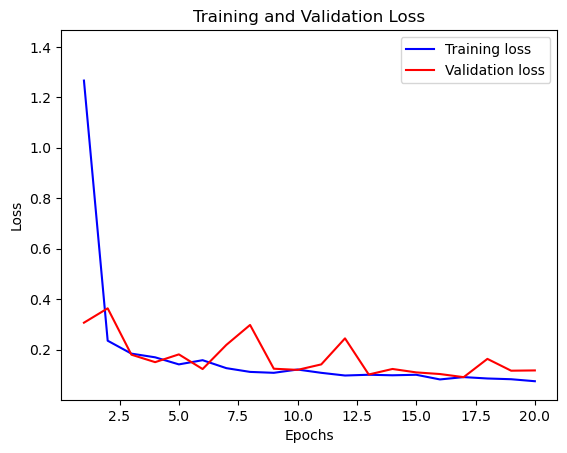

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.001, max(max(loss), max(val_loss))+0.2)
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss.png'))
plt.show()

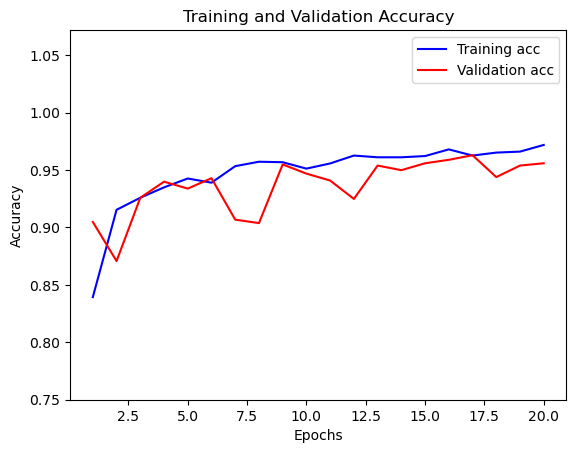

In [ ]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.75, max(max(acc), max(val_acc))+0.1)  # Adjust the upper limit dynamically if needed

plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy.png'))
plt.show()

In [ ]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

with open(os.path.join(folder_path, 'classification_report.txt'), 'w') as file:
    file.write(classification_rep)

32/32 [==============================] - 56s 2s/step
Classification Report:
               precision    recall  f1-score   support

      drowsy     0.9851    0.9601    0.9724       551
   notdrowsy     0.9523    0.9821    0.9670       447

    accuracy                         0.9699       998
   macro avg     0.9687    0.9711    0.9697       998
weighted avg     0.9704    0.9699    0.9700       998



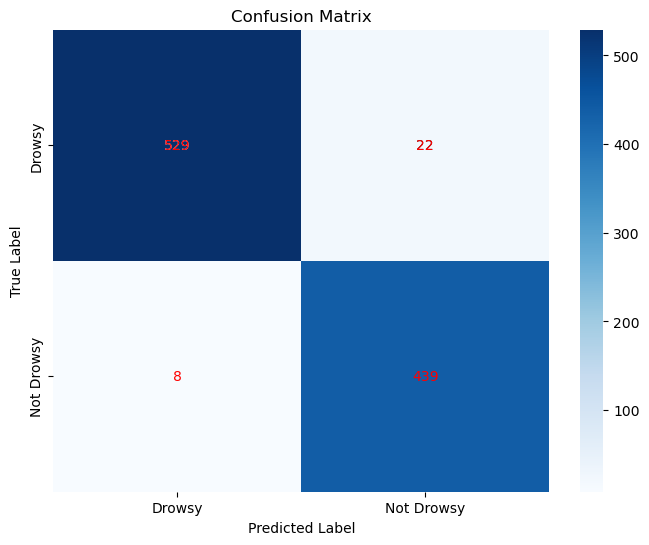

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Drowsy', 'Not Drowsy'], yticklabels=['Drowsy', 'Not Drowsy'])

# Loop through the elements of the confusion matrix to add annotations for both top and bottom
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha='center', va='center', color='red')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
val_acc_avg = np.mean(val_acc)
print("Average Validation ACcuracy",val_acc_avg)

Average Validation ACcuracy 0.9365731447935104


In [ ]:
acc_avg = np.mean(acc)
print("Average training ACcuracy",val_acc_avg)

Average training ACcuracy 0.9365731447935104
